In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.efficientnet import EfficientNetB3

In [3]:
# Need to import archive.zip at every new runtime instance
!unzip archive.zip

Archive:  archive.zip
  inflating: flower_photos/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flower_photos/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flower_photos/daisy/10172379554_b296050f82_n.jpg  
  inflating: flower_photos/daisy/10172567486_2748826a8b.jpg  
  inflating: flower_photos/daisy/10172636503_21bededa75_n.jpg  
  inflating: flower_photos/daisy/102841525_bd6628ae3c.jpg  
  inflating: flower_photos/daisy/1031799732_e7f4008c03.jpg  
  inflating: flower_photos/daisy/10391248763_1d16681106_n.jpg  
  inflating: flower_photos/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flower_photos/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flower_photos/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flower_photos/daisy/10466290366_cc72e33532.jpg  
  inflating: flower_photos/daisy/10466558316_a7198b87e2.jpg  
  inflating: flower_photos/daisy/10555749515_13a12a026e.jpg  
  inflating: flower_photos/daisy/10555815624_dc211569b0.jpg  
  inflating: flower_photos/daisy/10555826

In [2]:
def fit_model(lr, epochs, model):
    model.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(lr),
                 metrics=['accuracy'])

    checkpoint = ModelCheckpoint('best_model.h5.keras', save_best_only=True, monitor='val_accuracy', mode='max')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, baseline=None)

    return model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[checkpoint, early_stopping]
    )
def plot_stats(history, title, acc_range=[.2, 1], loss_range=[0,2]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.plot(history.history['accuracy'], label='accuracy')
    ax1.plot(history.history['val_accuracy'], label = 'val_accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(acc_range)
    ax1.set_title(title)
    ax1.legend(loc='lower right')

    ax2.plot(history.history['loss'], label='loss')
    ax2.plot(history.history['val_loss'], label = 'val_loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_ylim(loss_range)
    ax2.set_title(title)
    ax2.legend(loc='lower right')


In [3]:
image_dir = ["flower_photos"]

data = []

for flower_dir in image_dir:

        for subdir, _, files in os.walk(flower_dir):
            label = os.path.basename(subdir)
            for file in files:
                file_path = os.path.join(subdir, file)
                data.append([file_path, label])

label_df = pd.DataFrame(data, columns=['file', 'label'])

print(label_df.info())
print(label_df.columns)
label_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3670 entries, 0 to 3669
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    3670 non-null   object
 1   label   3670 non-null   object
dtypes: object(2)
memory usage: 57.5+ KB
None
Index(['file', 'label'], dtype='object')


,file,label
0,flower_photos/sunflowers/26254755_1bfc494ef1_n...,sunflowers
1,flower_photos/sunflowers/4821232343_7e0bcfbfdf...,sunflowers
2,flower_photos/sunflowers/15745084272_36402f5ee...,sunflowers
3,flower_photos/sunflowers/14121915990_4b7671807...,sunflowers
4,flower_photos/sunflowers/5830614551_e460a1215c...,sunflowers


In [4]:
# Augmenting the data for training
t_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)
v_datagen = ImageDataGenerator(rescale=1/255.0)

In [5]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(label_df, test_size=0.2, stratify=label_df['label'], random_state=42)

train_generator = t_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle = True,
    seed=10,
    # subset='training'
)

val_generator = v_datagen.flow_from_dataframe(
    dataframe = val_df,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle= False,
    seed=10,
    # subset='validation'
)

Found 2936 validated image filenames belonging to 5 classes.
Found 734 validated image filenames belonging to 5 classes.


In [15]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

enetb3_model = EfficientNetB3(include_top= False, weights='imagenet',
                           input_shape=(224, 224, 3), pooling='max')

pretrain_model = tf.keras.models.Sequential([
    enetb3_model,
    BatchNormalization(),

    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(5, activation='softmax')
])


In [16]:
history6 = fit_model(.00025, 50, pretrain_model)
print("Completed")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.4861 - loss: 1.5492 - val_accuracy: 0.2439 - val_loss: 2.5172
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 63s 450ms/step - accuracy: 0.8816 - loss: 0.3864 - val_accuracy: 0.2425 - val_loss: 4.2914
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 476ms/step - accuracy: 0.9135 - loss: 0.2288 - val_accuracy: 0.2616 - val_loss: 5.1597
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 480ms/step - accuracy: 0.9356 - loss: 0.1966 - val_accuracy: 0.5136 - val_loss: 2.3482
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 493ms/step - accuracy: 0.9589 - loss: 0.1126 - val_accuracy: 0.7834 - val_loss: 0.7741
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 510ms/step - accuracy: 0.9634 - loss: 0.1073 - val_accuracy: 0.8406 - val_loss: 0.6135
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 480ms/step - accuracy: 0.9742 - loss: 0.0778 - val_accuracy: 0.9019 - val_loss: 0.4016
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 48s 487ms/step - accuracy: 0.9707 - loss: 0.0895 - val_accuracy: 0.9223 

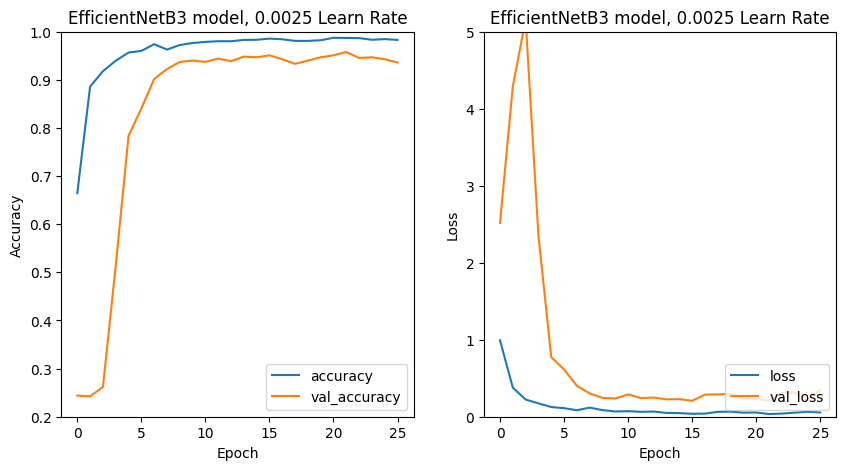

In [18]:
plot_stats(history6, "EfficientNetB3 model, 0.0025 Learn Rate", [.2, 1], [0, 5])

In [6]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

enetb3_model2 = EfficientNetB3(include_top= False, weights='imagenet',
                           input_shape=(224, 224, 3), pooling='max')

pretrain_model2 = tf.keras.models.Sequential([
    enetb3_model2,
    BatchNormalization(),

    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(5, activation='softmax')
])


In [7]:
history7 = fit_model(.0001, 50, pretrain_model2)
print("Completed")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.3833 - loss: 1.7723 - val_accuracy: 0.2439 - val_loss: 2.9462
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 498ms/step - accuracy: 0.7859 - loss: 0.5819 - val_accuracy: 0.2439 - val_loss: 3.5842
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 573ms/step - accuracy: 0.8711 - loss: 0.3509 - val_accuracy: 0.2861 - val_loss: 3.2645
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 571ms/step - accuracy: 0.8971 - loss: 0.2906 - val_accuracy: 0.3692 - val_loss: 2.2599
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 568ms/step - accuracy: 0.9336 - loss: 0.1896 - val_accuracy: 0.6294 - val_loss: 1.1921
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 565ms/step - accuracy: 0.9337 - loss: 0.1738 - val_accuracy: 0.7480 - val_loss: 0.8151
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 48s 499ms/step - accuracy: 0.9454 - loss: 0.1458 - val_accuracy: 0.8624 - val_loss: 0.4510
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 488ms/step - accuracy: 0.9579 - loss: 0.1192 - val_accuracy: 0.9033 

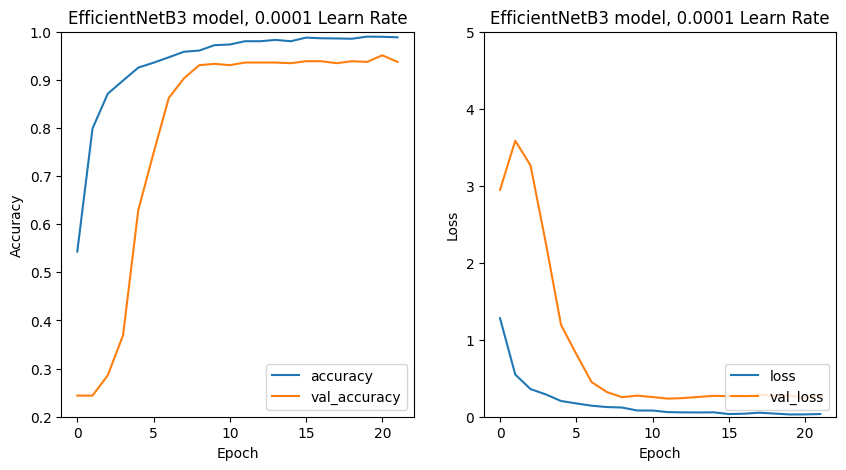

In [9]:
plot_stats(history7, "EfficientNetB3 model, 0.0001 Learn Rate", [.2, 1], [0, 5])